## Testing out iminuit fitting for FOM, will replace curve fit

In [1]:
# import stuff
import sys,os,os.path

sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

from    IC.invisible_cities.core.core_functions   import shift_to_bin_centers

import core.functions as func
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import probfit

import scipy.special as special
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

from scipy.integrate import quad

import iminuit
from iminuit import Minuit

### load and prepare data

In [2]:
folder_paths = ['75_9e-3/PORT_1a/isaura/', '75_9e-3/PORT_1b/isaura/', '75_9e-3/PORT_2a/isaura/', '75_9e-3/PORT_2b/isaura/']
full_tracks = func.collate_ports(folder_paths)

# apply cuts, SATELLITE TRACKS ARE DIFFERENT RN
#low_e_tracks = func.remove_low_E_events(full_tracks)
low_e_tracks = full_tracks[full_tracks.energy > 0.05]
# count the number of events identified with unique event, and change numb_of_tracks to reflect this
event_counts = low_e_tracks['event'].value_counts(sort = False)

# apply this to numb_of_tracks
low_e_tracks['numb_of_tracks'] = low_e_tracks['event'].map(event_counts)

cut_tracks = func.apply_cuts(low_e_tracks, lower_z = 20, upper_z = 1170, r_lim = 415)



Porting 75_9e-3/PORT_1a/isaura/
50
100
150
200
250
300
Done! Tracks available: 87009
Porting 75_9e-3/PORT_1b/isaura/
50
100
150
200
250
300
Tracks: 84703
Done! Tracks available: 152826
Porting 75_9e-3/PORT_2a/isaura/
50
100
150
200
250
300
Tracks: 60529
Done! Tracks available: 198973
Porting 75_9e-3/PORT_2b/isaura/
50
100
150
200
250
300
Tracks: 80864
Done! Tracks available: 259847


/tmp/ipykernel_69229/2704749952.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_e_tracks['numb_of_tracks'] = low_e_tracks['event'].map(event_counts)


Cutting events around fiducial volume related to:
Z range between 20 and 1170
Radius range < 415
Fiducial track cut
Relative Cut efficiency:
Efficiency: 39.84 %
Absolute Cut efficiency:
Efficiency: 39.84 %
One track cut
Relative Cut efficiency:
Efficiency: 64.26 %
Absolute Cut efficiency:
Efficiency: 52.09 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 72.74 %
Absolute Cut efficiency:
Efficiency: 72.42 %
Energy cut
Relative Cut efficiency:
Efficiency: 10.60 %
Absolute Cut efficiency:
Efficiency: 7.88 %


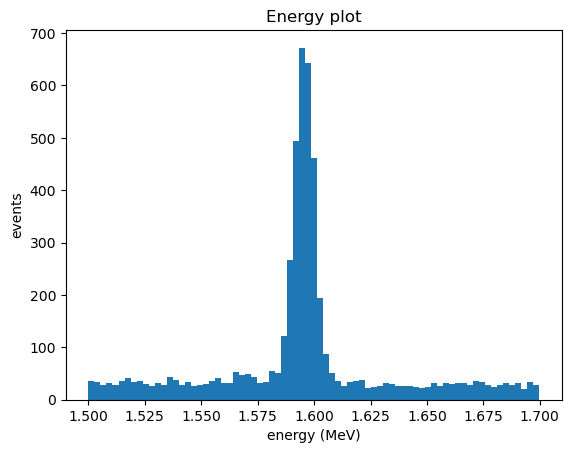

In [3]:
func.plot_hist(cut_tracks[0], binning = 75, log = False)

In [4]:
# find positron events per port
pos_events = func.positron_ports(folder_paths)

Loading positrons from 75_9e-3/PORT_1a/isaura/
Port finished! Tracks available: 13282
Loading positrons from 75_9e-3/PORT_1b/isaura/
Positron events: 12865
Port finished! Tracks available: 25717
Loading positrons from 75_9e-3/PORT_2a/isaura/
Positron events: 9663
Port finished! Tracks available: 34976
Loading positrons from 75_9e-3/PORT_2b/isaura/
Positron events: 12817
Port finished! Tracks available: 47202


In [5]:
# collect positron events and non-positron events
ecut_positron_df = cut_tracks[0][cut_tracks[0]['event'].isin(pos_events['event_id'].to_numpy())]
ecut_no_positron_df = cut_tracks[0][~cut_tracks[0]['event'].isin(pos_events['event_id'].to_numpy())]

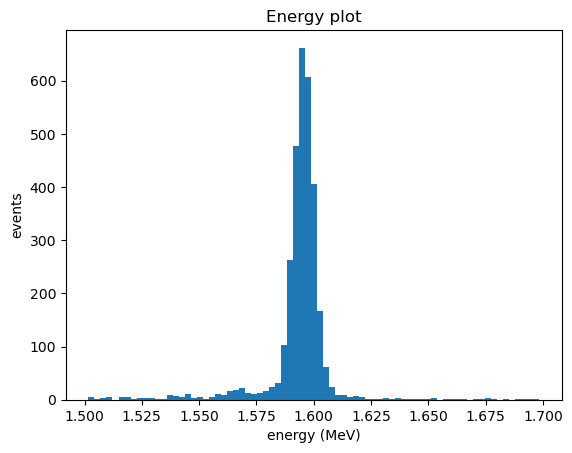

In [6]:
func.plot_hist(ecut_positron_df, binning = 75, log = False)

In [7]:
cut_list = np.linspace(0,0.6, 61)

# Fit
#fom_out_fit = func.fom_calc_MC(cut_tracks[0], pos_events, cut_list, binning = 60)

In [8]:
def fit(c, C1, C2, mu, sigma):
    m = Minuit(c, ns = 400, a = 1, nb = 20, tau = 0.1, C1 = C1, C2 = C2, mu = mu, sigma = sigma)
    m.fixed['mu'] = True
    m.fixed['sigma'] = True
    m.fixed['C1'] = True
    m.fixed['C2'] = True
    m.limits["ns", "nb"] = (0, None)
    m.migrad()
    assert m.valid
    return m

In [9]:
# create a distribution function for the bins
def integral(xe, ns, a, mu, sigma, C1, C2, nb, tau):

    return ns * skewnorm_func.cdf(x, a, mu, sigma) + C1 

### unbinned extended maximum likelihood fit for C1 C2 

In [10]:
# set range we're considering
fit_range = (1.5, 1.7)
binning = 80

In [11]:
# Normalise and extend
sig_norm = probfit.Normalized(func.sig_func_no_N, fit_range)
sig_norm_ext = probfit.Extended(sig_norm, extname = 'Ns')

In [61]:

e_s = ecut_positron_df['energy'].to_numpy()
#e_s = cut_tracks[0]['energy'].to_numpy()

# create unbinned likelihood object for fitting
lh_s = probfit.UnbinnedLH(sig_norm_ext, e_s, extended = True)

# resolve bin edge problems
fit_bins = np.linspace(fit_range[0], fit_range[1], binning + 1)
y, x = np.histogram(e_s, fit_bins)
x = shift_to_bin_centers(x)



# give it rough starting spots
vals = [len(e_s), 0, 1.58, 0.3, 0, 0]
nm = ['Ns', 'a', 'mu', 'sigma', 'C1', 'C2']



params = dict(Ns = len(e_s), a = 0, mu = 1.58, sigma=0.3, C1 = 0, C2 = 0)
m = Minuit(lh_s, **dict(zip(nm, vals)), limit_mu=(1.4,1.7), limit_C1=(0,None),
         limit_C2=(0,None), limit_sigma=(0,None), print_level = 2)
#m.limits['mu'] = (1.4, 1.7)
#m.limits['C1'] = (0, None)
#m.limits['C2'] = (0, None)
#m.limits['sigma'] = (0, None)



In [62]:
# minimise that mfer
m.migrad()

VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =  -29689.44352174 Edm =      1562.15 NCalls =     72
VariableMetric: Iteration #   0 - FCN =  -29689.44352174 Edm =      1562.15 NCalls =     72
VariableMetric: Iteration #   1 - FCN =  -31245.53859823 Edm =      4101.86 NCalls =     93
VariableMetric: Iteration #   2 - FCN =  -32701.34672537 Edm =      154.269 NCalls =    115
VariableMetric: Iteration #   3 - FCN =  -32748.75879748 Edm =      97.5243 NCalls =    129
VariableMetric: Iteration #   4 - FCN =  -32785.39340618 Edm =      6.77937 NCalls =    143
VariableMetric: Iteration #   5 - FCN =  -32789.28646603 Edm =      8.52043 NCalls =    157
VariableMetric: Iteration #   6 - FCN =  -32793.78683505 Edm =      1.10539 NCalls =    171
VariableMetric: Iteration #   7 - FCN =  -32801.06577986 Edm =       2.8386 NCalls =    187
VariableMetric: Iteration #   8 - FCN =  -32810.06312682 Edm =       3.7456 NCalls =    205
VariableMetric: Iteration 

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -3.282e+04                 │        Nfcn = 410 (410 total)        │
│ EDM = 2.28e-05 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a     │    0.0    │    0.8    │            │            │         │         │       │
│ 1 │ mu    │  1.5955   │  0.0028   │            │            │   1.4   │   1.7   │       │
│ 2 │ sigma │  4.44e-3  │  0.13e-3  │            │            │    0    │         │       │
│ 3 │ C1    │   0.000   │   0.004   │            │            │    0    │         │       │
│ 4 │ C2    │   0.64    │   0.04    │            │            │    0    │         │       │
│ 5 │ Ns    │  3.13e3   │  0.05e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

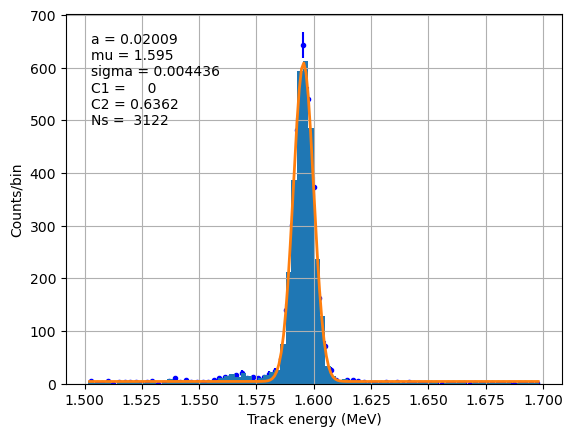

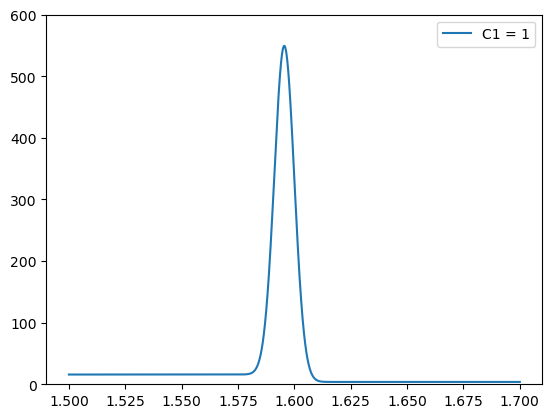

In [86]:
# plot output



heights, bins, _ = plt.hist(e_s, binning)
plt.xlabel("Track energy (MeV)")
plt.ylabel("Counts/bin")
lh_s.show(bins=binning+1, parts=True)



C1_test = 1
x_points = np.linspace(1.5, 1.7, 20000)                 # C1 PARAMETER HERE
y_points = func.sig_func(x_points, 6, 0.02, 1.5955, 0.004436, C1_test, 0.6362)
plt.plot(x_points, y_points, label = 'C1 = {}'.format(C1_test))
plt.ylim([0,600])
plt.legend()
plt.show()

In [2]:
print("iminuit version:", iminuit.__version__)

iminuit version: 2.25.2


In [91]:

e_s2 = np.append(e_s, e_s2)
#e_s = cut_tracks[0]['energy'].to_numpy()

# create unbinned likelihood object for fitting
lh_s = probfit.UnbinnedLH(sig_norm_ext, e_s2, extended = True)

# resolve bin edge problems
fit_bins = np.linspace(fit_range[0], fit_range[1], binning + 1)
y, x = np.histogram(e_s2, fit_bins)
x = shift_to_bin_centers(x)



# give it rough starting spots
vals = [len(e_s2), 0, 1.58, 0.3, 0, 0]
nm = ['Ns', 'a', 'mu', 'sigma', 'C1', 'C2']



params = dict(Ns = len(e_s2), a = 0, mu = 1.58, sigma=0.3, C1 = 0, C2 = 0)
m2 = Minuit(lh_s, **dict(zip(nm, vals)), limit_mu=(1.4,1.7), limit_C1=(0,None),
         limit_C2=(0,None), limit_sigma=(0,None), print_level = 2)
#m.limits['mu'] = (1.4, 1.7)
#m.limits['C1'] = (0, None)
#m.limits['C2'] = (0, None)
#m.limits['sigma'] = (0, None)


In [92]:
# minimise that mfer
m2.migrad()

VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =  -99587.67616363 Edm =      4856.07 NCalls =     94
VariableMetric: Iteration #   0 - FCN =  -99587.67616363 Edm =      4856.07 NCalls =     94
VariableMetric: Iteration #   1 - FCN =  -103883.8363617 Edm =      6118.56 NCalls =    119
VariableMetric: Iteration #   2 - FCN =  -108560.6179698 Edm =       914.85 NCalls =    143
VariableMetric: Iteration #   3 - FCN =  -108715.0329486 Edm =      451.082 NCalls =    159
VariableMetric: Iteration #   4 - FCN =  -108822.0763603 Edm =      29.2179 NCalls =    173
VariableMetric: Iteration #   5 - FCN =  -108830.6308968 Edm =      14.9261 NCalls =    187
VariableMetric: Iteration #   6 - FCN =  -108842.8533993 Edm =      4.13233 NCalls =    201
VariableMetric: Iteration #   7 - FCN =  -108850.6622825 Edm =      1.94108 NCalls =    215
VariableMetric: Iteration #   8 - FCN =  -108871.5466668 Edm =      10.4149 NCalls =    233
VariableMetric: Iteration 

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -1.089e+05                 │        Nfcn = 376 (376 total)        │
│ EDM = 2.87e-05 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a     │   0.49    │   0.28    │            │            │         │         │       │
│ 1 │ mu    │  1.5939   │  0.0008   │            │            │   1.4   │   1.7   │       │
│ 2 │ sigma │  4.73e-3  │  0.31e-3  │            │            │    0    │         │       │
│ 3 │ C1    │   0.361   │   0.023   │            │            │    0    │         │       │
│ 4 │ C2    │   0.297   │   0.020   │            │            │    0    │         │       │
│ 5 │ Ns    │  9.39e3   │  0.10e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

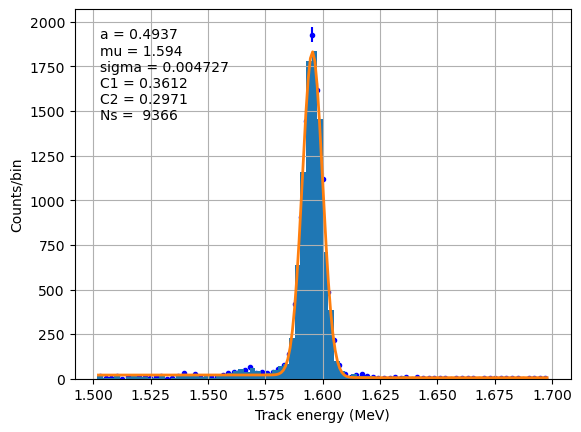

((array([1.5017215 , 1.50414975, 1.50657799, 1.50900624, 1.51143449,
         1.51386274, 1.51629099, 1.51871923, 1.52114748, 1.52357573,
         1.52600398, 1.52843222, 1.53086047, 1.53328872, 1.53571697,
         1.53814522, 1.54057346, 1.54300171, 1.54542996, 1.54785821,
         1.55028646, 1.5527147 , 1.55514295, 1.5575712 , 1.55999945,
         1.5624277 , 1.56485594, 1.56728419, 1.56971244, 1.57214069,
         1.57456894, 1.57699718, 1.57942543, 1.58185368, 1.58428193,
         1.58671018, 1.58913842, 1.59156667, 1.59399492, 1.59642317,
         1.59885142, 1.60127966, 1.60370791, 1.60613616, 1.60856441,
         1.61099266, 1.6134209 , 1.61584915, 1.6182774 , 1.62070565,
         1.6231339 , 1.62556214, 1.62799039, 1.63041864, 1.63284689,
         1.63527514, 1.63770338, 1.64013163, 1.64255988, 1.64498813,
         1.64741637, 1.64984462, 1.65227287, 1.65470112, 1.65712937,
         1.65955761, 1.66198586, 1.66441411, 1.66684236, 1.66927061,
         1.67169885, 1.6741271 , 1

In [94]:
heights, bins, _ = plt.hist(e_s2, binning)
plt.xlabel("Track energy (MeV)")
plt.ylabel("Counts/bin")
lh_s.show(bins=binning+1, parts=True)